## Time-lapse field application
This study has been demonstrated in the EMagPy paper [McLachlan et al. (2021)](https://doi.org/10.1016/j.cageo.2020.104561).

Time-lapse EMI can be used to monitor the change in soil moisture in the field. In this case, time-lapse EMI survey were collected under different winter wheat varieties. We can invert the EMI data by computing the change in ECa and inverting this change using the Gauss-Newton solver (`CSgn`) as demonstrated in [Whalley et al. (2017)](https://doi.org/10.1007/s11104-016-3161-1).

The figure below shows the evolution of the inverted change in electrical conductivity throughout the growth season (a to d) and of the measured soil moisture content from neutron probe (e to h). EC and WC changes are expressed as absolute difference relative to 2017-03-16 (models a and e). Deeper and larger decrease in EC is observed throughout the season mainly (b, c and d) following the change in soil moisture (f, g and h) mainly driven by root water uptake.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime
import pandas as pd
from scipy import stats
import sys
sys.path.append('../src') # add path where emagpy is
from emagpy import Problem

datadir = '../src/examples/'

letters = ['a','b','c','d','e','f','g','h','i','j']

In [2]:
# inversion of change
fnames = [
        datadir + 'timelapse-wheat/eca2017-03-16.csv',
        datadir + 'timelapse-wheat/eca2017-04-03.csv',
        datadir + 'timelapse-wheat/eca2017-04-27.csv',
        datadir + 'timelapse-wheat/eca2017-05-16.csv']
k = Problem()
k.createTimeLapseSurvey(fnames) # import all surveys
# k.setInit(depths0=np.linspace(0.1, 2, 10)) # smooth multiple fixed depths model
k.setInit(depths0=np.array([0.225, 0.4  , 0.6  , 0.85 , 1.125, 1.35]))
k.computeApparentChange() # compute change in ECa compared to first survey
k.invert(forwardModel='CSgn', alpha=0.07) # Gauss-Newton routine

Trimming surveys and only keep common positions
Matching positions between surveys for time-lapse inversion...20 in common...done in 0.0061s
Computing relative ECa compared to background (1st survey).
Survey 1/4
20/20 inverted
Survey 2/4
20/20 inverted
Survey 3/4
20/20 inverted
Survey 4/4
20/20 inverted


In [3]:
# we use the structure of EMagPy to import the soil moisture data and plot them
fnamesWC = [
        datadir + 'timelapse-wheat/wc2017-03-16.csv',
        datadir + 'timelapse-wheat/wc2017-04-05.csv',
        datadir + 'timelapse-wheat/wc2017-04-26.csv',
        datadir + 'timelapse-wheat/wc2017-05-18.csv',
        ]
kwc = Problem()
kwc.importModel(fnamesWC)
kwc.computeChange()

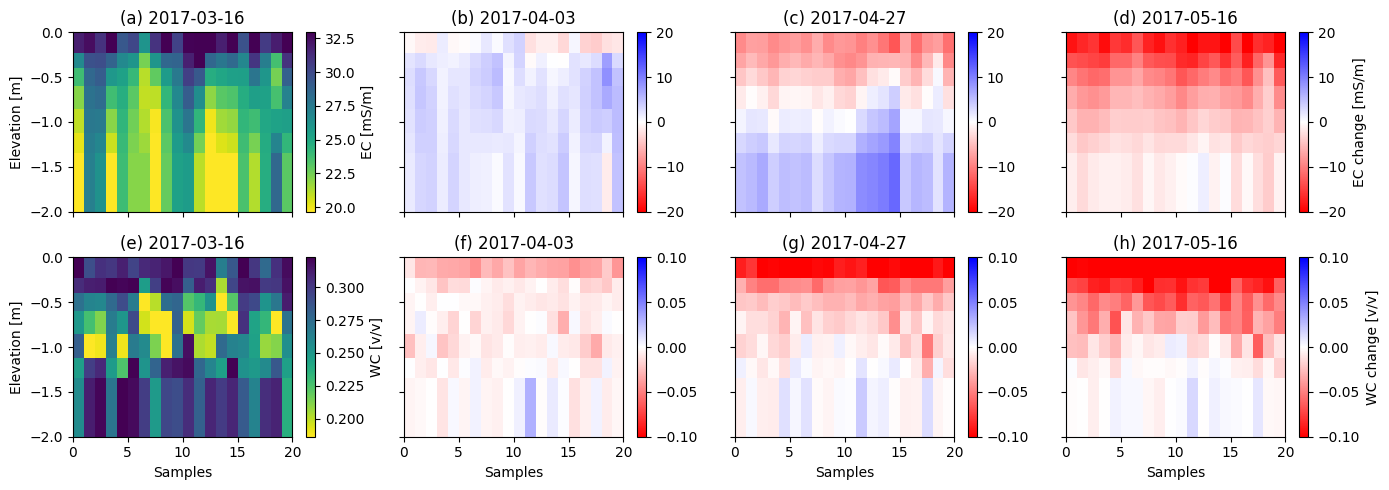

In [4]:
# graph of inverted conductivities change relative to background
rmse = k.getRMSE()
fig, axs = plt.subplots(2, 4, figsize=(14, 5), sharex=True, sharey=True)
for i, s in enumerate(k.surveys):
    ax = axs[0, i]
    if i == 0:
        k.showResults(i, ax=ax, contour=False, maxDepth=2)
    else:
        k.showResults(i, ax=ax, vmin=-20, vmax=20, cmap='bwr_r', contour=False, maxDepth=2)
    ax.set_title('({:s}) {:s}'.format(letters[i], s.name[3:]))
    ax.set_xlabel('')
    if i > 2:
        fig.axes[-1].set_ylabel('EC change [mS/m]')
    if i > 0:
        ax.set_ylabel('')
        if i != 3:
            fig.axes[-1].set_ylabel('')
    
    ax = axs[1, i]
    if i == 0:
        kwc.showResults(i, ax=ax, contour=False, maxDepth=2)
        fig.axes[-1].set_ylabel('WC [v/v]')
    else:
        kwc.showResults(i, ax=ax, cmap='bwr_r', vmin=-0.1, vmax=0.1, contour=False, maxDepth=2)
    ax.set_title('({:s}) {:s}'.format(letters[i+4], s.name[3:]))
    if i > 2:
        fig.axes[-1].set_ylabel('WC change [v/v]')
    if i > 0:
        ax.set_ylabel('')
        if i != 3:
            fig.axes[-1].set_ylabel('')
fig.tight_layout()

Rs=0.70, p=0.000, Rs^2=0.49


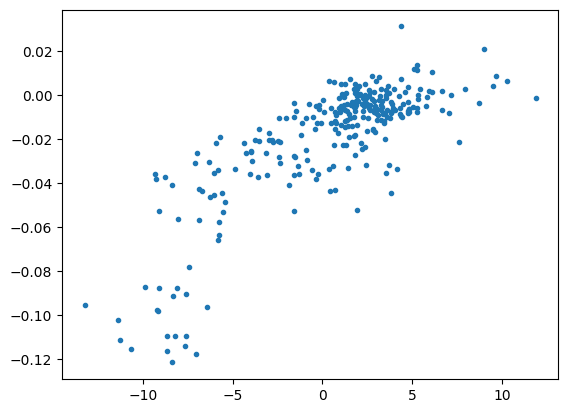

In [5]:
# computing correlation
ec = np.array([k.models[i].flatten() for i in range(1, 3)]).flatten()
wc = np.array([kwc.models[i].flatten() for i in range(1, 3)]).flatten()
fig, ax = plt.subplots()
ax.plot(ec, wc, '.')
corr, pval = stats.spearmanr(ec, wc)
print('Rs={:.2f}, p={:.3f}, Rs^2={:.2}'.format(corr, pval, corr**2))